<a href="https://colab.research.google.com/github/Filip-GG/HuTu80/blob/main/mian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Filip-GG/HuTu80

Cloning into 'HuTu80'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 373 (delta 0), reused 3 (delta 0), pack-reused 367 (from 1)
Receiving objects: 100% (373/373), 590.88 MiB | 16.52 MiB/s, done.
Updating files: 100% (361/361), done.


# Dowloand dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("user164919/hutu-80")

print("Path to dataset files:", path)

100%|██████████| 589M/589M [01:53<00:00, 5.43MB/s] 

Extracting files...


Path to dataset files: C:\Users\Filic\.cache\kagglehub\datasets\user164919\hutu-80\versions\1


# Imports module

In [2]:
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from PIL import Image

Device mode

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Data processing

Open dataset folder

In [4]:
imgnet_data = torchvision.datasets.ImageFolder('./hutu-80/images')
mask_data = torchvision.datasets.ImageFolder('./hutu-80/masks')

train test split:

In [5]:
from sklearn.model_selection import  train_test_split

img_train, img_test, mask_train, mask_test = train_test_split(
    imgnet_data,
    mask_data,
    test_size = 0.2,
    random_state = 42
    )

In [6]:
img_transforms = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize((520, 694)),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
])

1. Convert PIL Image to Torch Tensor
2. Re size (1040, 1388) -> (260, 347)
3. Convert data to float
4. Normalize values

In [7]:
mask_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(1),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize((520, 694)),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.Normalize(mean=1, std=-1),
])

1. Gray
2. Convert PIL Image to Torch Tensor
3. Re size (1040, 1388) -> (260, 347)
4. Convert data to float
5. Normalize values

# class Dataset

In [8]:
class ImgDataset(torch.utils.data.Dataset):
    """Some Information about ImgDataset"""
    def __init__(self, imgnet, masks, img_transforms, mask_transforms):
        super(ImgDataset, self).__init__()
        self.imgnet = imgnet
        self.masks = masks
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

    def __getitem__(self, index):
        img = self.imgnet[index][0]
        lable = self.masks[index][0]

        img = self.img_transforms(img)
        lable = self.mask_transforms(lable)

        return (img, lable)

    def __len__(self):
        return len(self.imgnet)

In [9]:
data_train = ImgDataset(img_train, mask_train, img_transforms, mask_transforms)
data_test = ImgDataset(img_test, mask_test, img_transforms, mask_transforms)

Dataloader

In [10]:
batch_size = 1

dataloader_train = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size, shuffle=False)

# Load model (Net)

In [13]:
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=1,
    weights_backbone=torchvision.models.ResNet101_Weights.IMAGENET1K_V2
)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 198MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

# Image sampling

In [100]:
def img_sampl(data):
  data = data > 0.5
  data = data * 1
  data = data.float()
  return data

In [102]:
img_sampl(torch.Tensor([1, 0]))

tensor([1., 0.])

# Pixel accuracy func

In [86]:
def pixel_acc(predict_tensot, lable_rensot):

    predict_tensot = img_sampl(predict_tensot)
    lable_rensot = lable_rensot

    correct_pixels = (predict_tensot == lable_rensot).count_nonzero()
    uncorrect_pixels = (predict_tensot != lable_rensot).count_nonzero()
    result = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

    return result


# Acc model

In [87]:
def accuracy_model(model, test_loader):
    score = []
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        out = model(inputs)

        score.append(pixel_acc(out['out'], labels))

    return score


# Training function

In [88]:
def train(model, testloader, trainloader, optimizer, criterion, epoch, save = False):

    loss_stats = {
        'loss_func': [],
        'Pixel Acc': []
    }

    for ep in range(epoch):

        model.train()

        running_loss = 0.0
        for data in (bar := tqdm(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs['out'], labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            bar.set_description(f'epoch: {ep}\tloss: {running_loss:.3F}')

        loss_stats['loss_func'].append(running_loss)

        model.eval()

        loss_stats['Pixel Acc'].append(accuracy_model(model, testloader))

    return loss_stats

# Train

In [89]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [41]:
stats = train(
    model,
    dataloader_test,
    dataloader_train,
    optimizer,
    criterion,
    100
)

100%|██████████| 36/36 [00:01<00:00, 28.41it/s]


In [42]:
median_acc = list(map(lambda x: sum(x)/len(x), stats['Pixel Acc']))

In [43]:
from matplotlib import pyplot as plt
import pylab

100%|██████████| 144/144 [00:05<00:00, 28.58it/s]


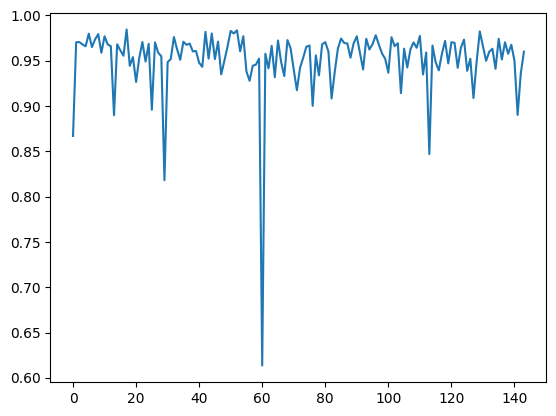

In [92]:
plt.plot(accuracy_model(model, dataloader_train))

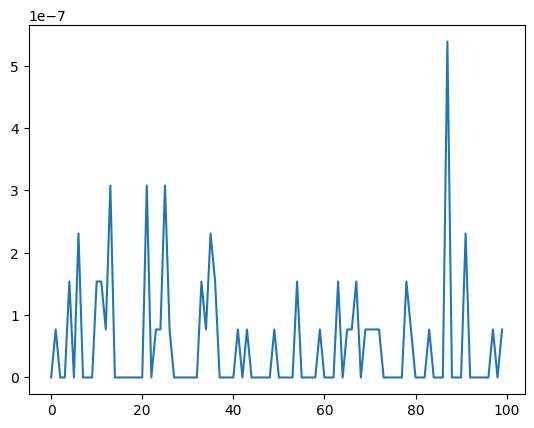

In [45]:
plt.plot(median_acc)

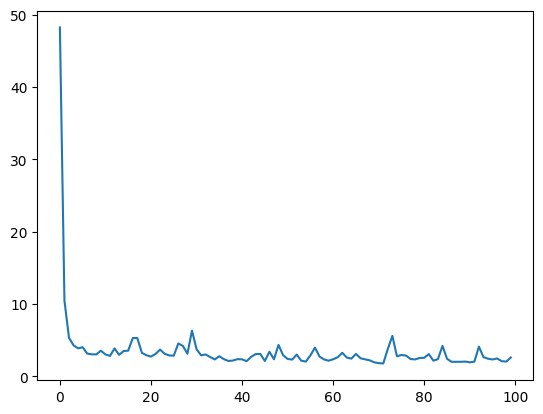

In [46]:
plt.plot(stats['loss_func'])

Testing model:

In [98]:
def test(model, test_loader):
    for data in tqdm(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        trans_RGB = torchvision.transforms.ToPILImage('RGB')
        trans_L = torchvision.transforms.ToPILImage('L')

        out = model(inputs)

        fig, ax = plt.subplots(ncols=3)
        ax[0].imshow(trans_RGB(inputs.to('cpu')[0]))
        ax[1].imshow(trans_L(labels.to('cpu')[0]))
        ax[2].imshow(trans_L(img_sampl(out['out']).to('cpu')[0]))

        fig.show()


 56%|█████▌    | 20/36 [00:01<00:01, 13.60it/s]<ipython-input-98-ffb4c296d865>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=3)
100%|██████████| 36/36 [00:02<00:00, 12.94it/s]


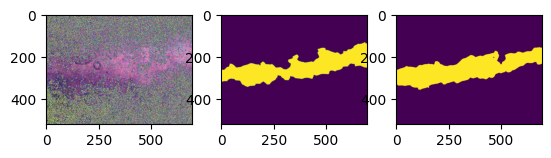

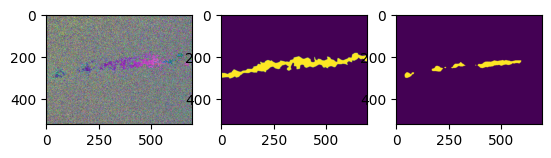

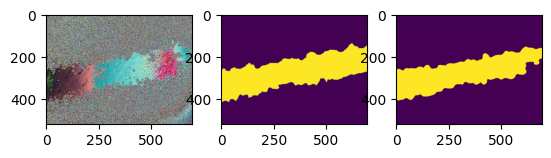

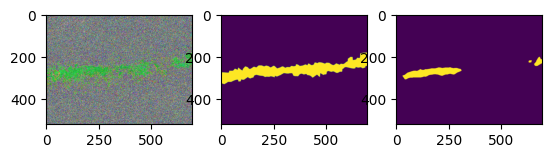

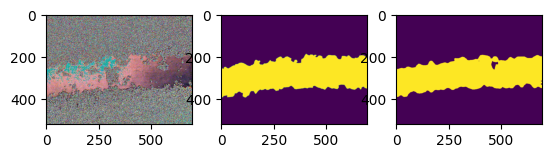

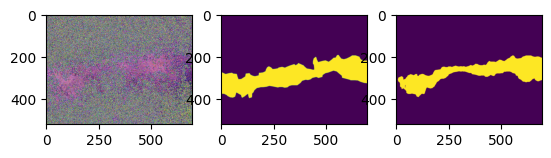

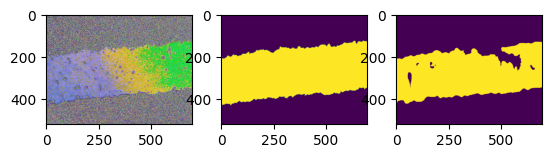

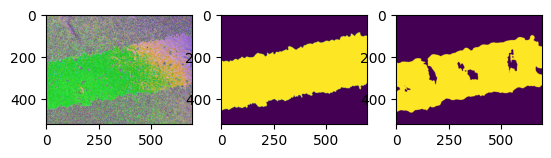

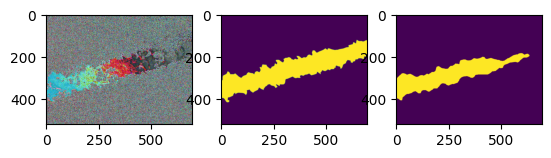

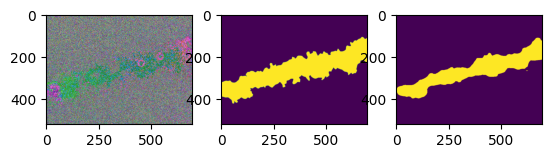

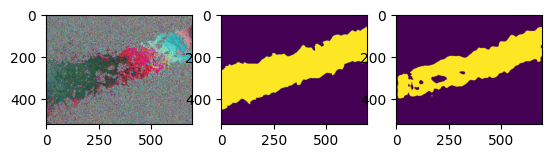

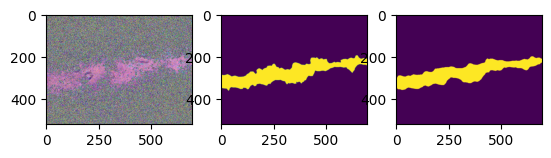

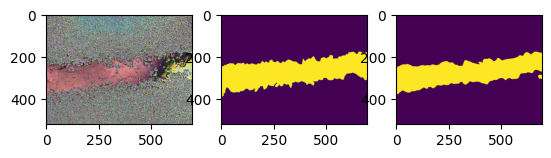

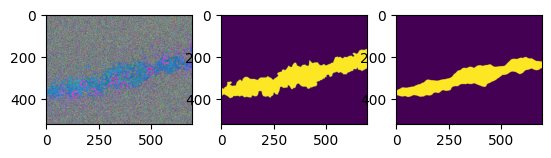

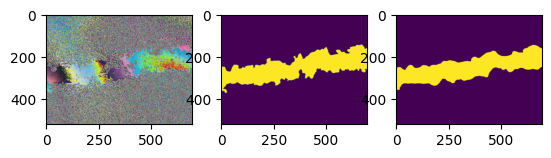

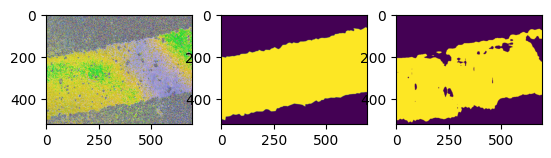

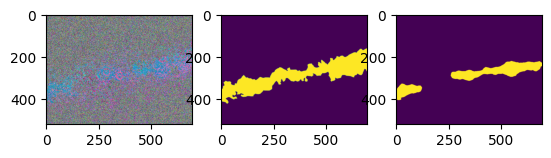

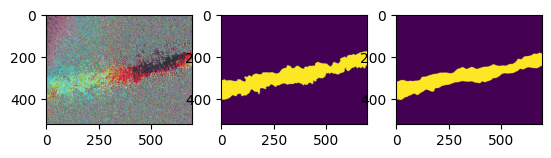

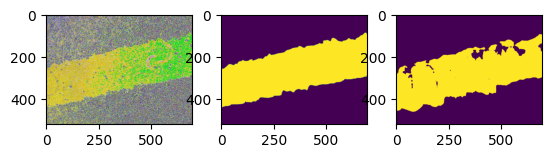

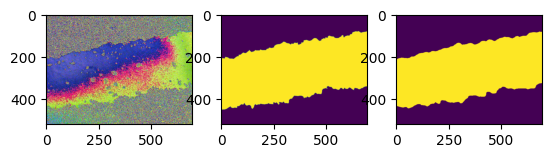

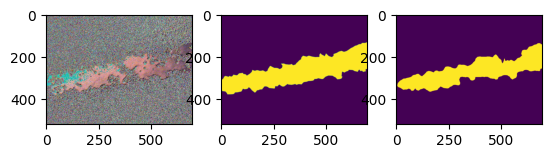

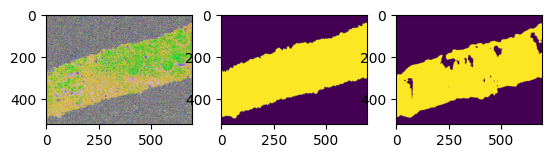

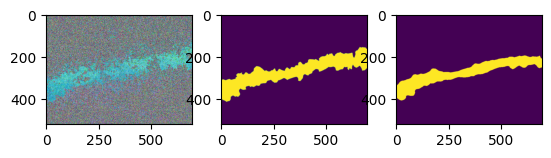

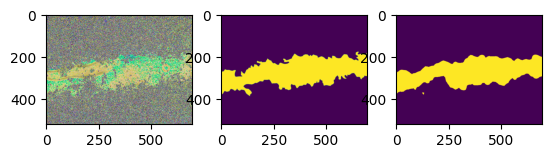

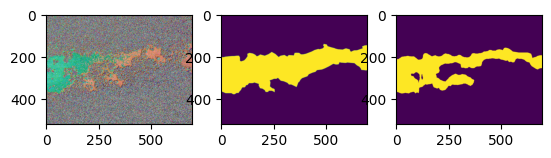

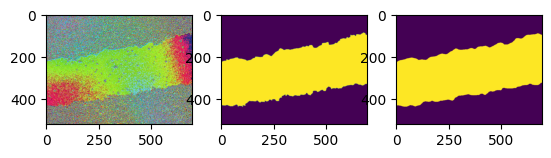

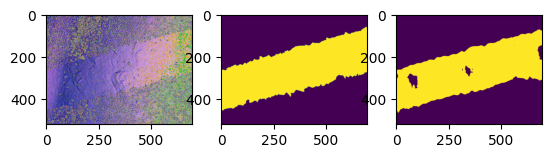

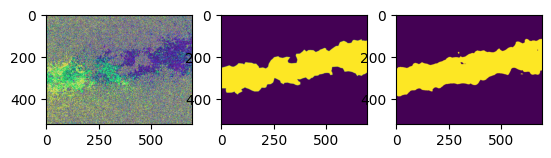

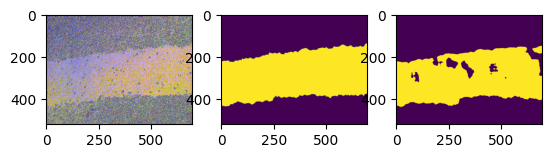

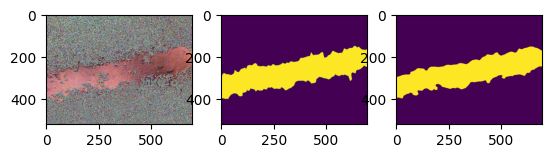

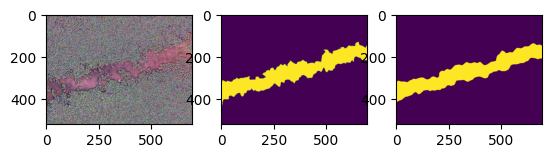

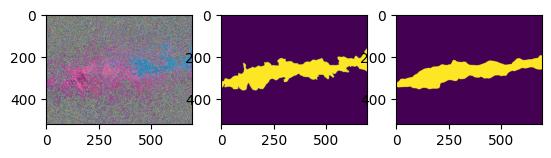

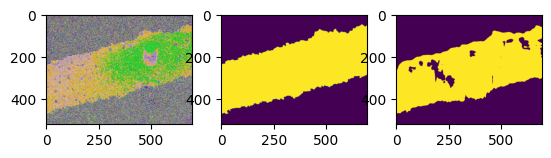

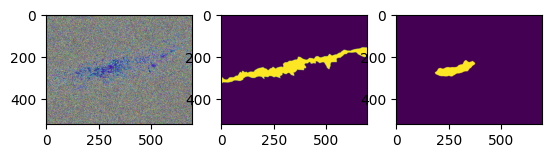

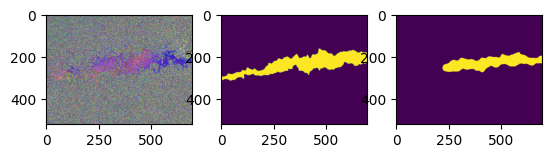

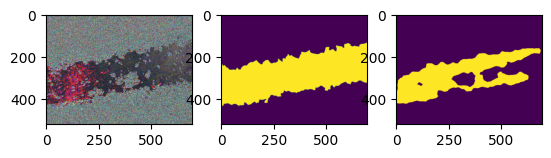

In [103]:
test(model, dataloader_test)

Save model:

In [ ]:
torch.save(model.state_dict(), 'my_model.pth')

Load Model:

In [ ]:
model = torchvision.models.segmentation.fcn_resnet101(
    num_classes=3,
    weights_backbone=torchvision.models.ResNet101_Weights.IMAGENET1K_V1
)
model.load_state_dict(torch.load('my_model.pth'))

RuntimeError: Error(s) in loading state_dict for FCN:
	size mismatch for classifier.4.weight: copying a param with shape torch.Size([1, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
	size mismatch for classifier.4.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([3]).